In [124]:
import torch
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
seed = 221
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Loading Dataset

In [127]:
train = pd.read_csv('../train.csv', index_col=0)
val = pd.read_csv('../valid.csv', index_col=0)
test = pd.read_csv('../test.csv', index_col=0)

In [128]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11426 entries, 0 to 11425
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   11426 non-null  object
 1   sentiment  11426 non-null  int64 
 2   topic      11426 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 357.1+ KB


In [129]:
train.drop(columns=['topic'], axis=1, inplace=True)
val.drop(columns=['topic'], axis=1, inplace=True)
test.drop(columns=['topic'], axis=1, inplace=True)

In [130]:
train = pd.concat([train, val])

In [131]:
test['sentiment'].unique()

array([2, 0, 1], dtype=int64)

In [132]:
train.head()

,sentence,sentiment
0,slide giáo trình đầy đủ .,2
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2
2,đi học đầy đủ full điểm chuyên cần .,0
3,chưa áp dụng công nghệ thông tin và các thiết ...,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2


# Random Forest + TF-IDF

In [133]:
x_train = train['sentence'].to_list()
y_train = train['sentiment'].to_list()

x_test = test['sentence'].to_list()
y_test = test['sentiment'].to_list()

In [134]:
vietnamese_stopwords = [
    'a', 'anh', 'ai', 'bài', 'bên', 'biết', 'các', 'cái', 'cần', 'chỉ', 'chia', 'cho', 'chúng', 'chung', 'có', 'còn', 
    'cũng', 'cả', 'cùng', 'của', 'cứ', 'cuối', 'đã', 'đang', 'đây', 'để', 'đến', 'đi', 'đó', 'đều', 'em', 'gì', 'hoặc', 
    'khi', 'không', 'là', 'lại', 'lên', 'lúc', 'mà', 'mình', 'một', 'nào', 'này', 'nên', 'nếu', 'người', 'như', 'nhưng', 
    'nhiều', 'những', 'rằng', 'ra', 'rất', 'rồi', 'sau', 'sẽ', 'thấy', 'thì', 'trên', 'trong', 'tôi', 'từ', 'tại', 'và', 
    'vẫn', 'vào', 'vì', 'với', 'được', 'đây', 'đó', 'ông', 'bà', 'chúng tôi', 'họ', 'các bạn'
]

In [135]:
tfidf = TfidfVectorizer(smooth_idf=True, strip_accents='unicode', stop_words=vietnamese_stopwords, lowercase=True, encoding='utf-8', analyzer='word', ngram_range=(1, 3), max_features=5000)

In [ ]:
encoded_x_train = tfidf.fit_transform(x_train)
encoded_x_test = tfidf.transform(x_test)

In [137]:
encoded_x_train

<13009x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 274494 stored elements in Compressed Sparse Row format>

In [138]:
random_forest = RandomForestClassifier(criterion='gini', bootstrap=True, n_estimators=100, random_state=seed)

In [139]:
random_forest

RandomForestClassifier(random_state=221)

In [140]:
random_forest.fit(encoded_x_train, y_train)

RandomForestClassifier(random_state=221)

In [141]:
predict = random_forest.predict(encoded_x_test)
predict

array([2, 2, 2, ..., 2, 0, 0])

In [142]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1409
           1       0.60      0.13      0.21       167
           2       0.91      0.88      0.90      1590

    accuracy                           0.87      3166
   macro avg       0.78      0.65      0.66      3166
weighted avg       0.86      0.87      0.86      3166



In [143]:
input = ["Thầy dạy dễ hiểu"]
x = tfidf.transform(input)
random_forest.predict(x)

array([2])

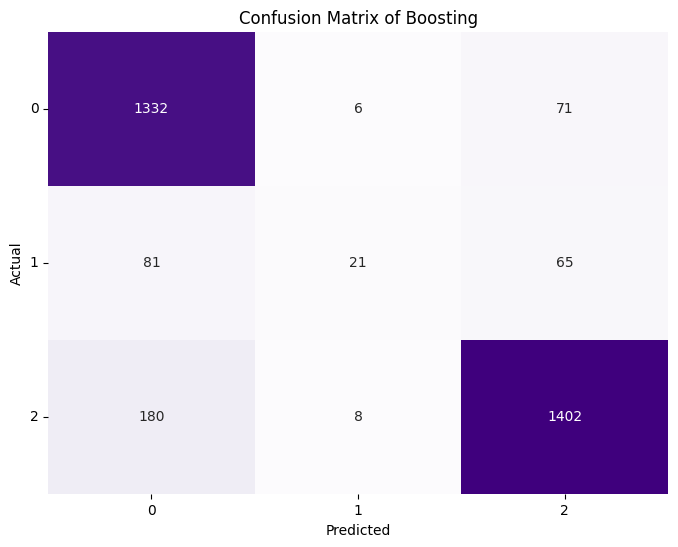

In [144]:
conf_ma = confusion_matrix(y_test, predict)
labels = ['0', '1', '2'] # 0: negative, 1: neutral, 2: positive
plt.figure(figsize=(8, 6))
sns.heatmap(conf_ma, annot=True, cmap='Purples', fmt='g', cbar=False)

# Add labels, title, and ticks
plt.title('Confusion Matrix of Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.show()